# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail(3))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail(3))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,Turkey,Iran,China,Russia,...,Holy See,MS Zaandam,Papua New Guinea,Mauritania,Western Sahara,Bhutan,Burundi,Sao Tome and Principe,South Sudan,Yemen
2020-04-19,759086,198674,178972,154097,145184,121172,86306,82211,83805,42853,...,8,9,7,7,6,5,5,4,4,1
2020-04-20,784326,200210,181228,156480,147065,125856,90980,83505,83817,47121,...,9,9,7,7,6,5,5,4,4,1
2020-04-21,823786,204178,183957,159297,148291,130172,95591,84802,83853,52763,...,9,9,7,7,6,6,5,4,4,1


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Belgium,Iran,Germany,China,Netherlands,...,Dominica,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,Sao Tome and Principe,Seychelles,Sierra Leone,Chad,Central African Republic,Rwanda
2020-04-19,40661,23660,20453,19744,16095,5683,5118,4586,4636,3697,...,0,0,0,0,0,0,0,0,0,0
2020-04-20,42094,24114,20852,20292,16550,5828,5209,4862,4636,3764,...,0,0,0,0,0,0,0,0,0,0
2020-04-21,44845,24648,21282,20829,17378,5998,5297,5033,4636,3929,...,0,0,0,0,0,0,0,0,0,0


## Add Trailing Avg Changes 3-day 7-day 14day

In [ ]:
#
#


## Add Global Population by Country

In [557]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head())  

display(dfc_g.iloc[0:1,:].count(axis=1), df_gmerged['Country/Region'].count())  # join check 185 in -> 159 out ?


,Country/Region,Deaths,Cases,Country Code,Year,Population
7,China,4636,83853,CHN,2016,1378665000
17,India,645,20080,IND,2016,1324509589
0,United States,44845,823786,USA,2016,322941311
18,Indonesia,616,7135,IDN,2016,261554226
9,Brazil,2741,43079,BRA,2016,206163058


2020-01-22    185
dtype: int64

159

## Add Various Other Data from WorldBank.Org

In [558]:
# all available indicators https://data.worldbank.org/indicator
#    API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#    I should bundle into a single request XLS or Json results, but alas.. this works for now
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [559]:
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)


df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])

df_gmerged3.head()


,Country/Region,Deaths,Cases,Country Code,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,44845,823786,USA,322941311,9879630.00,7.41,3.68,2.9,150462.3,82.26,0.0,35.77,62794.59,0.00,0.00,5.2,94.0,15.81,20.83
2,Spain,21282,204178,ESP,46484062,641020.00,9.70,13.96,3.0,15618.0,80.32,0.0,93.53,39715.44,98.44,0.00,5.1,93.0,19.38,51.67
1,Italy,24648,183957,ITA,60627498,256596.00,16.75,9.89,3.4,16788.3,70.44,0.0,205.45,41830.43,99.16,0.00,4.9,95.0,22.75,50.26
3,France,20829,159297,FRA,66721256,597412.00,11.81,8.43,6.5,28241.0,80.44,0.0,122.34,45342.40,0.00,0.79,6.0,96.0,20.03,45.16
6,Germany,5033,148291,DEU,82348669,922648.64,12.03,3.04,8.3,33440.0,77.31,0.0,237.37,53074.54,0.00,0.00,4.8,93.0,21.46,72.11


# Correlation Matrix

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.924736,0.179280,0.728079,-0.157106,0.016636,0.085686,0.706605,0.179928,-0.178288,-0.025872,0.249353,-0.204658,-0.116660,-0.159934,0.090017,0.305885,-0.078415
Cases,0.924736,1.000000,0.222132,0.880891,-0.126158,-0.012797,0.076478,0.825029,0.164720,-0.159855,-0.023408,0.245582,-0.202405,-0.084702,-0.148778,0.082273,0.245441,-0.089882
Population,0.179280,0.222132,1.000000,0.503798,0.267416,-0.049807,-0.036975,0.612453,-0.060774,0.009955,-0.017312,-0.042647,0.024591,-0.026367,-0.018070,0.029798,0.010736,-0.141224
flights,0.728079,0.880891,0.503798,1.000000,-0.055782,-0.070206,0.057644,0.910928,0.141160,-0.138750,-0.024821,0.222829,-0.182516,-0.089135,-0.146960,0.089789,0.181807,-0.101634
pollution,-0.157106,-0.126158,0.267416,-0.055782,1.000000,0.034698,-0.385119,-0.033383,-0.230348,0.477390,-0.100991,-0.172031,0.132855,0.111566,0.416183,-0.111487,-0.466812,-0.100274
unemp%,0.016636,-0.012797,-0.049807,-0.070206,0.034698,1.000000,-0.002011,-0.011623,0.120080,0.026280,-0.125099,-0.148474,0.237484,0.130979,0.009034,-0.098822,0.062347,-0.019466
hospbeds,0.085686,0.076478,-0.036975,0.057644,-0.385119,-0.002011,1.000000,0.138858,0.388271,-0.565877,0.332303,0.305930,-0.010130,-0.163978,-0.513351,0.295807,0.601188,0.223852
railways,0.706605,0.825029,0.612453,0.910928,-0.033383,-0.011623,0.138858,1.000000,0.142949,-0.172386,-0.042580,0.182165,-0.167972,-0.069401,-0.162519,0.078569,0.251617,-0.128805
urbanpop%,0.179928,0.164720,-0.060774,0.141160,-0.230348,0.120080,0.388271,0.142949,1.000000,-0.478795,0.181979,0.606855,-0.022595,-0.110195,-0.532877,0.334991,0.408456,0.181994
slum%,-0.178288,-0.159855,0.009955,-0.138750,0.477390,0.026280,-0.565877,-0.172386,-0.478795,1.000000,-0.113728,-0.551982,-0.078594,0.289491,0.799900,-0.276597,-0.605509,-0.244386


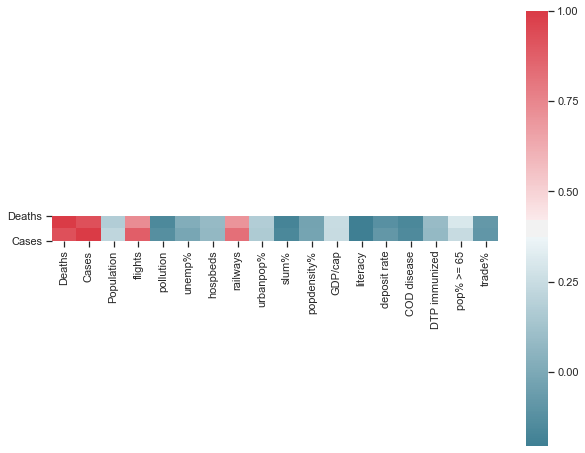

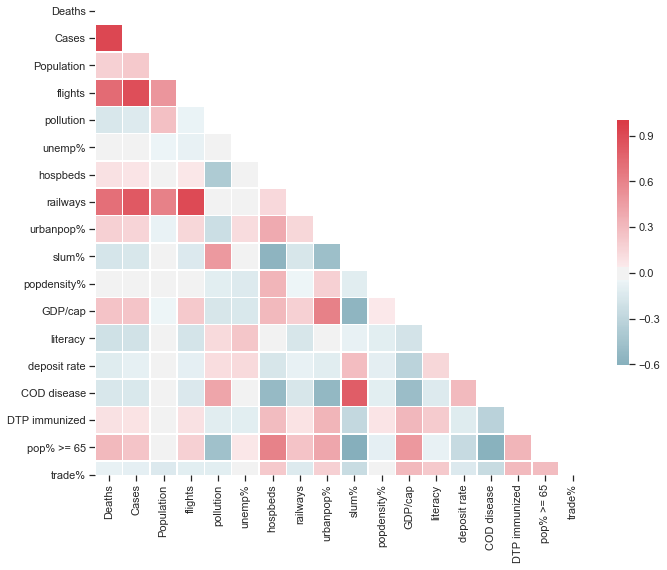

In [560]:
import seaborn as sns

df_corr = df_gmerged3.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [561]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_sc = df_gmerged3.copy().set_index('Country/Region').drop(columns=['Country Code'])
display('orig',df_sc.head(2))

df_sc = pd.DataFrame(scaler.fit_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
display('scale',df_sc.head(2))

# df_sc = pd.DataFrame(scaler.inverse_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
# display('inverse',df_sc.head(2))

'orig'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,44845,823786,322941311,9879630.0,7.41,3.68,2.9,150462.3,82.26,0.0,35.77,62794.59,0.00,0.0,5.2,94.0,15.81,20.83
Spain,21282,204178,46484062,641020.0,9.70,13.96,3.0,15618.0,80.32,0.0,93.53,39715.44,98.44,0.0,5.1,93.0,19.38,51.67


'scale'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,9.014499,11.335596,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,4.162011,2.650556,0.026889,0.472386,-0.894881,1.370712,0.060101,0.686980,0.871687,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125


# Misc Clustering Techniques

## - Basic Template for KMeans

In [562]:
from sklearn.model_selection import train_test_split

df_train = df_sc.copy()

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels

def fl_col(df, f=3, l=9):  # print first 3 and last 2 cols together
    return pd.concat([df.iloc[:,0:f],df.iloc[:,-l:]], axis=1)
    
df_train.insert(0, 'cluster', kmeans.labels_)
display('train', fl_col(pd.concat([df_train.head(5),
                            df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])]])))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())


'kmeans info - inertia: 1907.3783992946358, iters: 9'

'labels: [1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 0 2\n 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 0 0\n 2 0 0 2 2 2 2 0 2 2 0 0 2 0 0 2 0 0 2 0 2 2 0 2 2 2 2 0 0 0 2 0 0 2 0 2 0\n 0 0 0 2 0 0 0 2 0 0 2 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 2 0 2 0 2 0 2\n 0 2 2 2 2 0 0 0 0 0 0]'

'train'

,cluster,Deaths,Cases,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,1,9.014499,11.335596,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,2,4.162011,2.650556,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125
Italy,2,4.855194,2.367119,-0.882278,-0.080319,0.893110,0.819156,-0.814337,-0.787174,0.461891,2.124220,-0.305249
France,2,4.068721,2.021460,-0.882278,-0.130833,1.047433,-1.967469,-0.635091,-0.734424,0.517655,1.712609,-0.446759
Germany,2,0.815744,1.867189,-0.882278,-0.060918,1.387199,-1.967469,-0.814337,-0.791969,0.350364,1.929007,0.301027
United States,1,9.014499,11.335596,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,2,4.162011,2.650556,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125
Italy,2,4.855194,2.367119,-0.882278,-0.080319,0.893110,0.819156,-0.814337,-0.787174,0.461891,2.124220,-0.305249
China,2,0.733987,0.963962,0.007618,-0.115024,-0.143651,0.753958,-0.473995,-0.839924,0.684946,0.334015,-0.757250


,Cases
cluster,
0,62
1,1
2,96


## - Basic Template for DBSCAN

I saw a presentation by Healy & McInnes on Youtube that basically said KMeans sucks, and we should use DBScan or their upgraded version HDBScan.   https://www.youtube.com/watch?v=ayZQj4llUSU&t=1824s


In [563]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_sc.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')
display(labels[0:10])

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

df_train.insert(0, 'cluster',clustering.labels_)
display('train2',pd.concat([fl_col(df_train).head(), 
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))


"model: DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',\n       metric_params=None, min_samples=2, n_jobs=None, p=None)"

array([-1,  0,  0,  1, -1,  1,  2, -1,  3,  3], dtype=int64)

'core_sample_indices_[0:10]: [ 1  2  3  5  6  8  9 10 11 12]'

'components_[0]: [ 4.16201065  2.65055635  0.02688869  0.47238554 -0.89488095  1.37071175\n  0.06010084  0.68698041  0.87168744 -0.88227803 -0.1483439   0.80017278\n  0.79892219 -0.81433719 -0.77758298  0.35036395  1.61424593 -0.26612507]'

'labels/fit_predict[0:10]: [-1  0  0  1 -1  1  2 -1  3  3]'

'train2'

,cluster,Deaths,Cases,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,-1,9.014499,11.335596,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,0,4.162011,2.650556,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125
Italy,0,4.855194,2.367119,-0.882278,-0.080319,0.893110,0.819156,-0.814337,-0.787174,0.461891,2.124220,-0.305249
France,1,4.068721,2.021460,-0.882278,-0.130833,1.047433,-1.967469,-0.635091,-0.734424,0.517655,1.712609,-0.446759
Germany,-1,0.815744,1.867189,-0.882278,-0.060918,1.387199,-1.967469,-0.814337,-0.791969,0.350364,1.929007,0.301027
United States,-1,9.014499,11.335596,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,0,4.162011,2.650556,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125
Italy,0,4.855194,2.367119,-0.882278,-0.080319,0.893110,0.819156,-0.814337,-0.787174,0.461891,2.124220,-0.305249
China,-1,0.733987,0.963962,0.007618,-0.115024,-0.143651,0.753958,-0.473995,-0.839924,0.684946,0.334015,-0.757250


,Count
cluster,
-1,10
0,2
1,2
2,2
3,139
4,2
5,2


---

# Dimension Reduction

## - PCA Method

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

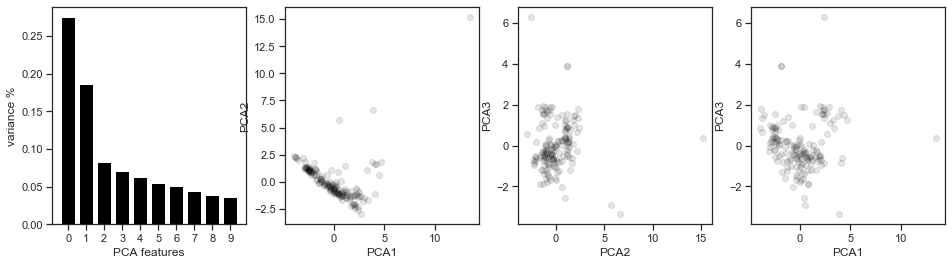

In [564]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_sc.copy()

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



## KMeans on PCA data

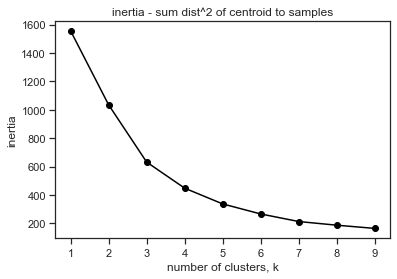

In [565]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
elbow_check(PCA_components)

## KMeans Cluster Variants and Plots

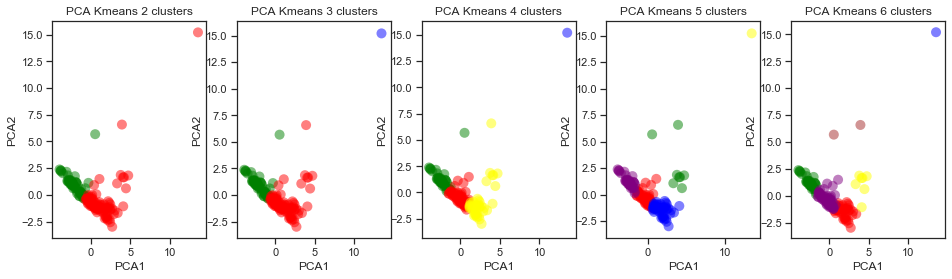

In [592]:
cluster_cases = [2,3,4,5,6]

def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
        kmeans = model.fit(df_comp2.iloc[:,:dims])
        df_comp2.insert(0, 'cluster', kmeans.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

# hmm which one to pick?
plot_clusters('PCA', cluster_cases, PCA_components)



## KMeans with Point Labels

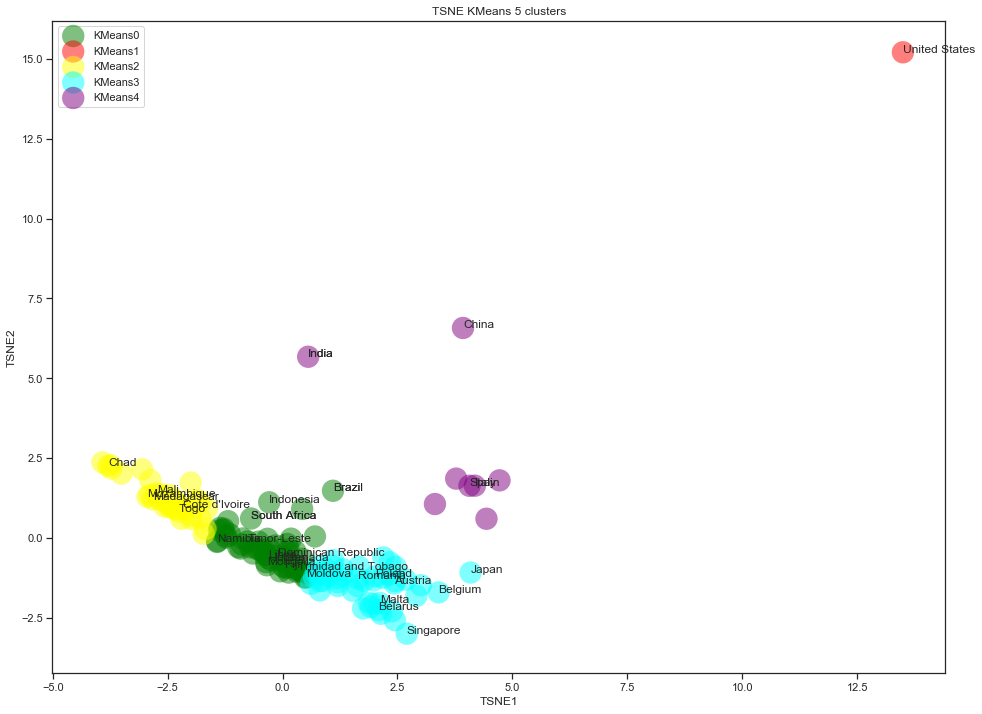

In [591]:
def plot_big(clustering_name, reducer_name, model, df_comp, dims=2):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    kmeans = model.fit(df_comp2.iloc[:,:dims])  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', kmeans.labels_)

    datas = []
    for i in range(clusters):
        tup = []
        for j in range(tsne_comps):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(clusters)]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {clusters} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index,row in df_comp2[df_comp2.index.isin(['China','Japan','United States','Singapore','South Africa','Belarus','Brazil','Italy','India','Poland'])].iterrows():
        ax.annotate(index, (row[0],row[1]))
    for index,row in df_comp2.sample(25).iterrows():
        ax.annotate(index, (row[0],row[1]))

    plt.legend(loc=2)
    plt.show()
    
# zoom on n cluster solution
clusters=5
model = KMeans(n_clusters=clusters)
plot_big('KMeans','TSNE',model, PCA_components)


## -T-SNE Method (T-Distributed Stochastic Neighbor Embedding)

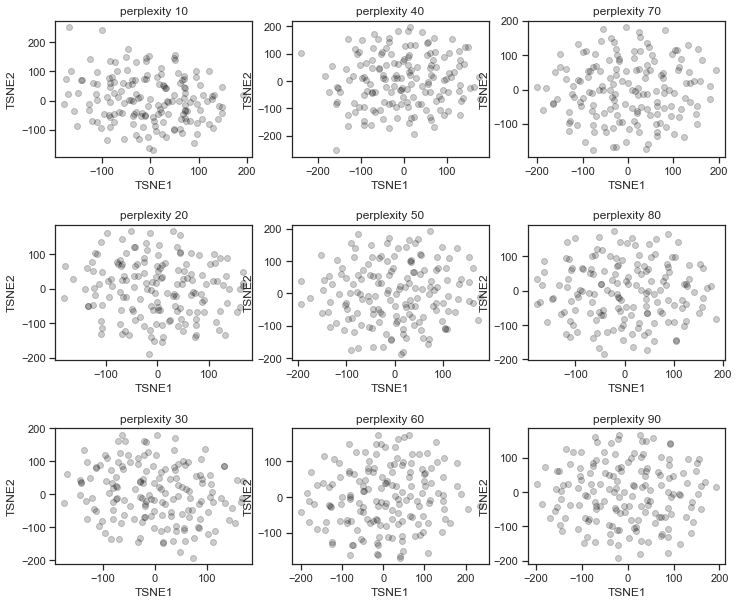

In [568]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=3, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


## Fixing TSNE HyperParams (Perplexity and Comps)

In [569]:
# pick perp 30 randomly, comps 2 or 3 (plot dimensions I think)
tsne_comps = 2
tsne_perp = 30
tsne = TSNE(n_components=tsne_comps, perplexity=tsne_perp)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,-9.572412,8.632577
Spain,-8.731743,7.749830
Italy,-8.717922,7.763184
France,-8.390390,8.526257
Germany,-4.630407,9.804158


## KMeans w/ TSNE

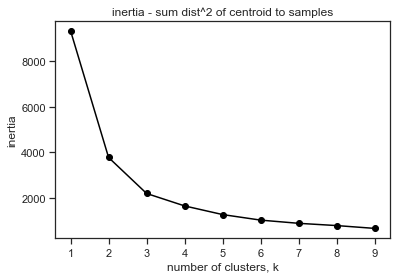

In [570]:
# KMeans on TSNE columns, search or the elbow ?

elbow_check(TSNE_components)

## KMeans on TSNE Cluster Analysis

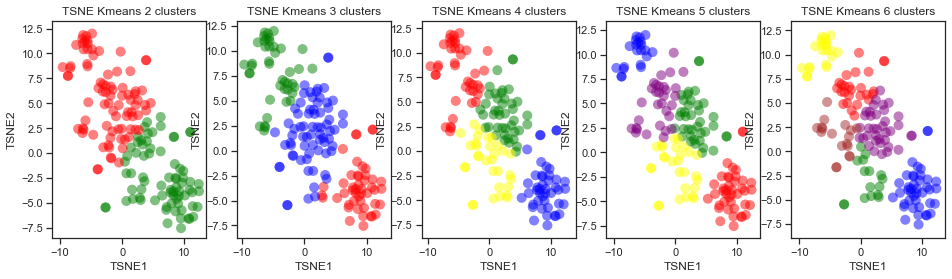

In [582]:
cluster_cases = [2,3,4,5,6]
plot_clusters('TSNE', cluster_cases, TSNE_components)

# hmm which one to pick?

## KMeans on TSNE - Zoom with Labels

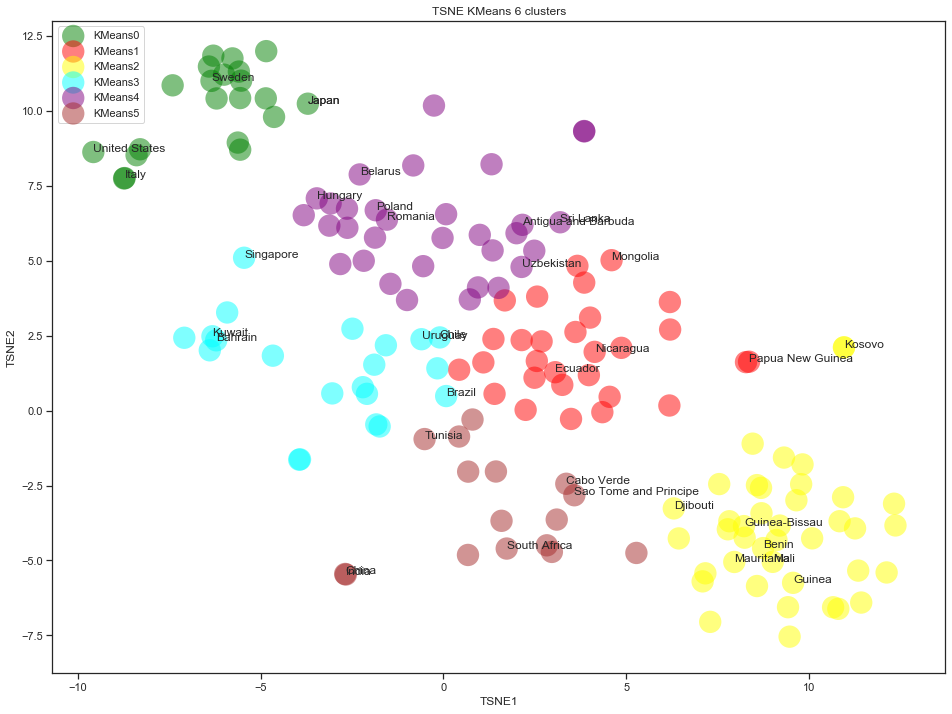

In [586]:
# try 6 clusters -- why i dunno, looks good... 
clusters = 6
model = KMeans(n_clusters=clusters, random_state=88)
    
plot_big('KMeans','TSNE',model, TSNE_components)